<a href="https://colab.research.google.com/github/Ton3t3/Lab2-RL/blob/main/problem%201/DQN_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# %cd ../..
!git clone https://github.com/Ton3t3/Lab2-RL

%cd Lab2-RL/problem 1

Cloning into 'Lab2-RL'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 80 (delta 44), reused 22 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (80/80), 1.66 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/Lab2-RL/problem 1


In [3]:
# Copyright [2025] [KTH Royal Institute of Technology]
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 2 for EL2805 - Reinforcement Learning.

# Load packages
from collections import deque, namedtuple

import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange
from DQN_agent import RandomAgent
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399014 sha256=ab787da6547c60ac2f4f11a59df1b3a31f23a43bf6acf62042198957a59d9ce2
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


Episode 99 - Reward/Steps: 96.5/945 - Avg. Reward/Steps: 25.6/799: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


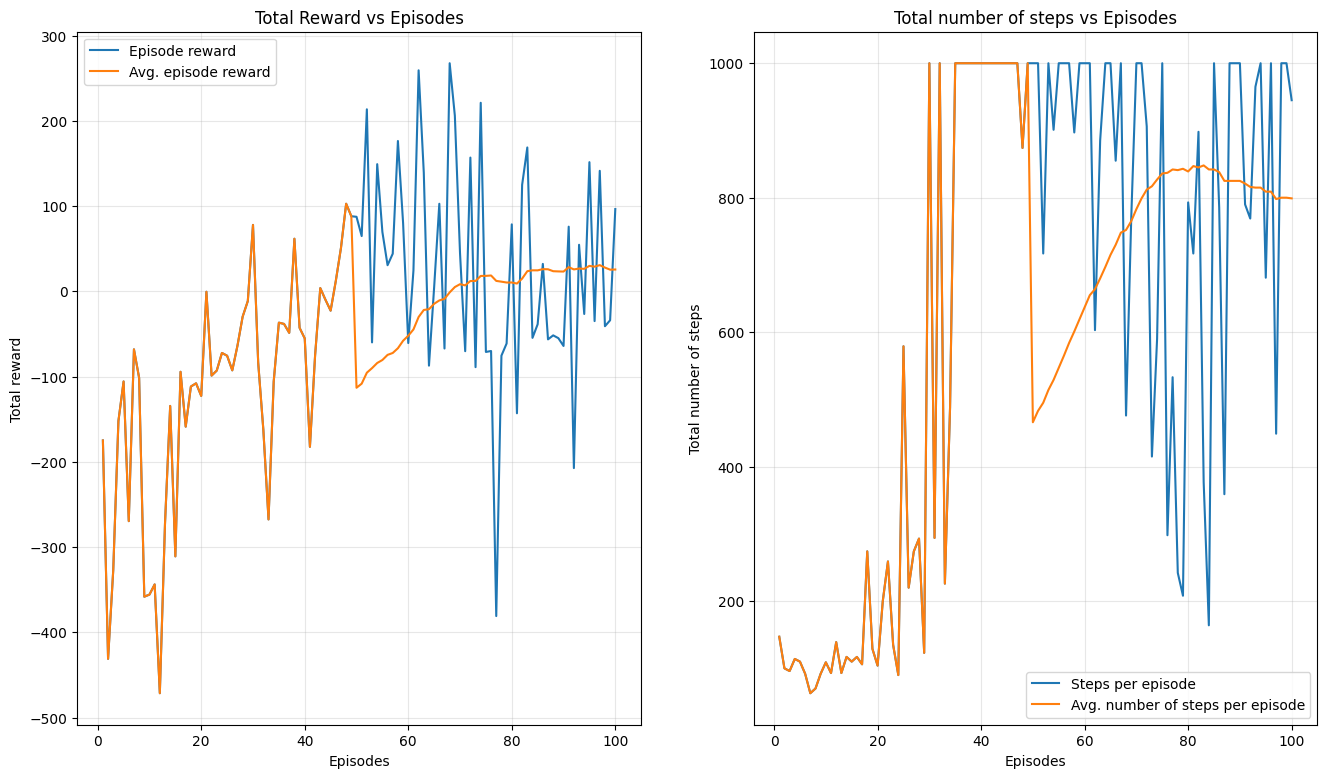

In [9]:

## EXPERIENCE REPLAY BUFFER IMPLEMENTATION
## (Copy from DQNelements_solved-1.py)

Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ExperienceReplayBuffer:
    """Replay buffer for storing experiences.

       The experience replay buffer stores past experiences so that the agent can learn from them later.
       By sampling randomly from these experiences, the agent avoids overfitting to the most recent
       transitions and helps stabilize training.
       - The buffer size is limited, and older experiences are discarded to make room for new ones.
       - Experiences are stored as tuples of (state, action, reward, next_state, done).
       - A batch of experiences is sampled randomly during each training step for updating the Q-values."""

    def __init__(self, maximum_length):
        self.buffer = deque(maxlen=maximum_length)  # Using deque ensures efficient removal of oldest elements

    def append(self, experience):
        """Add a new experience to the buffer"""
        self.buffer.append(experience)

    def __len__(self):
        """Return the current size of the buffer"""
        return len(self.buffer)

    def sample_batch(self, n):
        """Randomly sample a batch of experiences"""
        if n > len(self.buffer):
            raise IndexError('Sample size exceeds buffer size!')
        indices = np.random.choice(len(self.buffer), size=n, replace=False)  # Random sampling
        batch = [self.buffer[i] for i in indices]  # Create a batch from sampled indices
        return zip(*batch)  # Unzip batch into state, action, reward, next_state, and done
##
## NEURAL NETWORK IMPLEMENTATION
## (Copy from DQNelements_solved-1.py)

'''
INTERESTING PARAMETERS OF THE NEURAL NETWORK:
    · Number of layers -> 1
    · Number of neurons per layer -> 64
    · Number of hidden layers -> 1
    · Activation function -> ReLU
'''
class MyNetwork(nn.Module):
    """Feedforward neural network that approximates the Q-function.

       The network takes the current state as input and outputs Q-values for all possible actions.
       The action corresponding to the highest Q-value is considered the optimal action.
       - The input size corresponds to the state dimension of the environment.
       - The network has one hidden layer with 64 neurons and ReLU activation.
       - The output layer has one neuron per action (Q-values for each action)."""

    def __init__(self, input_size, output_size, neurons_per_layer):
        super().__init__()
        self.input_layer = nn.Linear(input_size, neurons_per_layer)  # First layer: state -> hidden layer
        self.hidden_layer = nn.Linear(neurons_per_layer, neurons_per_layer)  # Second layer: hidden -> hidden layer
        self.output_layer = nn.Linear(neurons_per_layer, output_size)  # Output layer: hidden -> Q-values
        self.activation = nn.ReLU()  # ReLU activation function for hidden layers

    def forward(self, x):
        """Define forward pass"""
        x = self.activation(self.input_layer(x))  # Apply input layer and ReLU
        x = self.activation(self.hidden_layer(x))  # Apply hidden layer and ReLU
        return self.output_layer(x)  # Return Q-values for all actions
##

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

# Import and initialize the discrete Lunar Lander Environment
env = gym.make('LunarLander-v3')
# If you want to render the environment while training run instead:
# env = gym.make('LunarLander-v3', render_mode = "human")

env.reset()

#Extra parameters (not included in raw version of the exercise)
BUFFER_SIZE = 15000#10000                                 # Size of the replay buffer (5000 - 30000)
TRAINING_BATCH = 64                                 # How big should be the batch of experiences used to train the main NN (4 - 128)
C = int(BUFFER_SIZE/TRAINING_BATCH)                 # Update frequency of the target
LEARNING_RATE = 0.0005#0.001                               # (10-3 - 10-4)
NEURONS_PER_LAYER = 64    #32                          # Number of neurons per hidden layer (8 - 128)
MIN_REPLAY_SIZE = 1000

# Parameters
N_episodes = 100 #100                             # Number of episodes
discount_factor = 0.97#0.95                       # Value of the discount factor
n_ep_running_average = 50                    # Running average of 50 episodes
n_actions = env.action_space.n               # Number of available actions
dim_state = len(env.observation_space.high)  # State dimensionality

# EXTRA PARAMETERS
Z = int(N_episodes*0.95)
EPSILON_MAX = 0.99
EPSILON_MIN = 0.05
EPSILON = 1

# Initialize buffer, network, and optimizer
buffer = ExperienceReplayBuffer(BUFFER_SIZE)
network = MyNetwork(input_size=env.observation_space.shape[0], output_size=env.action_space.n, neurons_per_layer=NEURONS_PER_LAYER)

target_network = MyNetwork(input_size=env.observation_space.shape[0], output_size=env.action_space.n, neurons_per_layer=NEURONS_PER_LAYER)
target_network.load_state_dict(network.state_dict())
target_network.eval()
network.to(dev)
target_network.to(dev)

optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)

def select_action(state, epsilon):
    """Epsilon-greedy action selection"""
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore by selecting a random action
    else: # 1-epsilon
        state_tensor = torch.tensor([state], dtype=torch.float32, device=dev)  # Convert state to tensor
        with torch.no_grad():
          return network(state_tensor).argmax().item()  # Exploit by selecting the action with max Q-value


# We will use these variables to compute the average episodic reward and
# the average number of steps per episode
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = []   # this list contains the number of steps per episode

# Random agent initialization
# agent = RandomAgent(n_actions)

### Training process
# trange is an alternative to range in python, from the tqdm library
# It shows a nice progression bar that you can update with useful information
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
global_counter = 0
episode_counter = 0
for i in EPISODES:
    # Reset enviroment data and initialize variables
    done, truncated = False, False
    state = env.reset()[0]
    total_episode_reward = 0.
    t = 0
    while not (done or truncated):
        if global_counter % C == 0:
          target_network.load_state_dict(network.state_dict())

        # Take a random action
        # action = agent.forward(state)
        action = select_action(state, EPSILON)

        # Get next state and reward
        next_state, reward, done, truncated, _ = env.step(action)

        # Update episode reward
        total_episode_reward += reward

        # Update state for next iteration
        ## Add new state to the buffer
        buffer.append(Experience(state, action, reward, next_state, done))
        state = next_state
        t+= 1
        global_counter+=1

        if len(buffer) >= MIN_REPLAY_SIZE:
          states, actions, rewards, next_states, dones = buffer.sample_batch(TRAINING_BATCH)
          # Convert the batch data into tensors
          states = torch.tensor(states, dtype=torch.float32, device=dev)
          actions = torch.tensor(actions, dtype=torch.int64, device=dev).unsqueeze(1)  # Unsqueeze for correct shape
          rewards = torch.tensor(rewards, dtype=torch.float32, device=dev)
          next_states = torch.tensor(next_states, dtype=torch.float32, device=dev)
          dones = torch.tensor(dones, dtype=torch.float32, device=dev)

          # Compute Q-values for the current states
          q_values = network(states).gather(1, actions).squeeze()  # Q-values for taken actions

          # Compute the target Q-values for the next states
          with torch.no_grad():  # No need to compute gradients for target Q-values
              next_q_values = target_network(next_states).max(1)[0]  # Max Q-value for next state
              targets = rewards + discount_factor * next_q_values * (1 - dones)  # Target: Bellman equation

          # Compute the loss (MSE loss between predicted Q-values and target Q-values)
          loss = nn.functional.mse_loss(q_values, targets)

          # Backpropagation step: update network parameters
          optimizer.zero_grad()  # Zero gradients before backpropagation
          loss.backward()  # Compute gradients
          nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)  # Clip gradients to avoid exploding gradients
          optimizer.step()  # Update parameters


    episode_counter +=1
    EPSILON = max(EPSILON_MIN, EPSILON_MAX * (EPSILON_MIN/EPSILON_MAX)**((episode_counter-1)/(Z-1)))
    # Append episode reward and total number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)


    # Updates the tqdm update bar with fresh information
    # (episode number, total reward of the last episode, total number of Steps
    # of the last episode, average reward, average number of steps)
    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

torch.save(network, 'neural-network-1.pth')
# Close environment
env.close()

# Plot Rewards and steps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()




In [10]:
%%python DQN_check_solution.py

Network model: MyNetwork(
  (input_layer): Linear(in_features=8, out_features=64, bias=True)
  (hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=4, bias=True)
  (activation): ReLU()
)
Checking solution...
Policy achieves an average total reward of -16.6 +/- 25.5 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than 50 with 95% confidence


Episode 49: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]
